In [2]:
from data_processing import Dataset
from noise import NoiseScheduler
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
import torch


In [3]:
baseDir='/hdfs/user/ys20884/hackathon/data'
dataset = Dataset(1_000, (120, 72), signal_file=f"{baseDir}/CaloImages_signal.root", pile_up_file=f"{baseDir}/CaloImages_bkg.root", save=False)

In [4]:
dataset() #once this is cached, you don't have to re-load

INFO:root:loading file /hdfs/user/ys20884/hackathon/data/CaloImages_signal.root
loading file /hdfs/user/ys20884/hackathon/data/CaloImages_signal.root
100%|██████████| 1000/1000 [00:01<00:00, 639.02it/s]
INFO:root:loading file /hdfs/user/ys20884/hackathon/data/CaloImages_bkg.root
loading file /hdfs/user/ys20884/hackathon/data/CaloImages_bkg.root
100%|██████████| 1000/1000 [00:01<00:00, 648.78it/s]


In [5]:
new_dim=(64,64)

In [6]:
dataset.preprocess(16, new_dim)

INFO:root:scaling
scaling
INFO:root:re-sizing
re-sizing


In [7]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

In [8]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)

In [31]:
i = 10
noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([1]) #each unit of timestep represents an addtional 5 pile-up events
random_seed = 42
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[i], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)


Mean: 0.004385859705507755
Max: 1.0
Min: 0.0


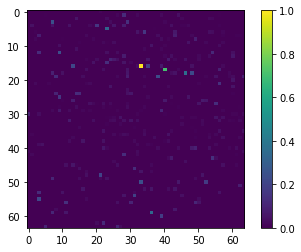

In [32]:

plt.imshow(noisy_image.reshape(new_dim))
plt.colorbar()
plt.title("Noised Image")

In [42]:
from models import Model, UNetLite
modtype = 'UNet_lite'

if modtype == 'UNet2d':
    model = Model('UNet', new_dim)
elif modtype == 'UNet_lite':
    model = UNetLite()

print(model)

UNetLite(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 4, eps=1e-05, affine=True)
      (2): ReLU()
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 4, eps=1e-05, affine=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 8, eps=1e-05, affine=True)
          (2): ReLU()
          (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GroupNorm(1, 8, eps=1e-05, affine=True)
          (5): ReLU()
        )
      )
    )
    (emb_layer): Sequential(
      (0): ReLU()
      (1): Linea

In [43]:
if modtype == 'UNet2d':
    model = model.__getitem__()

In [44]:
if modtype == 'UNet2d':
    trained_model_path = '/hdfs/user/ys20884/hackathon/trained_models/trained_diffusor.pt'
elif modtype == 'UNet_lite':
    trained_model_path = 'trained_models_lite-131744/model_epoch_5.pt'

print(trained_model_path)

trained_models_lite-131744/model_epoch_5.pt


In [45]:
checkpoint = torch.load(trained_model_path)

In [46]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

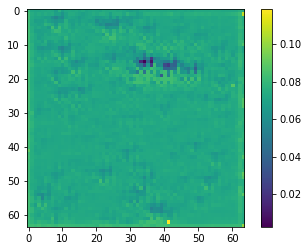

In [47]:
if modtype == 'UNet2d':
    noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0]
elif modtype == 'UNet_lite':
    noise_pred = model(noisy_image.unsqueeze(1), timestep)       #, return_dict=False)[0]

ims = plt.imshow(noise_pred.detach().numpy().reshape(new_dim))
plt.colorbar(ims)
plt.title("Noise Prediction")

In [48]:
de_noised = noisy_image[0] - (noise_pred.detach().numpy().reshape(new_dim))

Mean: -0.06758502870798111
Max: 0.9501456022262573
Min: -0.11856118589639664


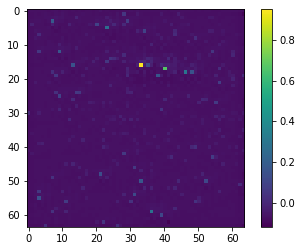

In [49]:

im = plt.imshow(de_noised.reshape(new_dim))
plt.colorbar(im)
plt.title("Denoised Image")

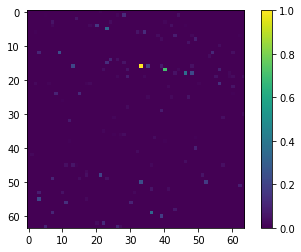

In [50]:
im2 = plt.imshow(clean_frames[i].squeeze())
plt.colorbar(im2)
plt.title("Clean Image")